In [44]:
import onnxruntime as ort
import numpy as np
import onnx
from collections import OrderedDict

from matplotlib import pyplot as plt

In [45]:
model_path = '/home/kanna/ml/models/badapple_in_nn/badapple_in_nn.onnx'
display_size = (360 // 3, 480 // 3)
interpreter_layers = 10

In [46]:
def softmax(x, dim):
    return np.exp(x) / np.sum(np.exp(x), axis=dim, keepdims=True)

In [47]:
ort_session = ort.InferenceSession(model_path)
org_outputs = [x.name for x in ort_session.get_outputs()]

model = onnx.load(model_path)
for node in model.graph.node:
    for output in node.output:
        if output not in org_outputs:
            model.graph.output.extend([onnx.ValueInfoProto(name=output)])

# excute onnx
ort_session = ort.InferenceSession(model.SerializeToString())

In [48]:
org_outputs

['output']

In [49]:

layer_output_names = [x.name for x in ort_session.get_outputs()]
in_img = np.zeros((1, 81 * 81)).astype(np.float32)
in_img[0, 313] = 1
in_img = in_img.reshape(1, 81, 81)
ort_outs = ort_session.run(layer_output_names, {'input': in_img} )
ort_outs = OrderedDict(zip(layer_output_names, ort_outs))

In [50]:
layer_output_names

['output',
 '/Constant_output_0',
 '/Reshape_output_0',
 '/input_to_display/MatMul_output_0',
 '/hidden_layers/hidden_layers.0/linear/MatMul_output_0',
 '/hidden_layers/hidden_layers.0/relu/Relu_output_0',
 '/hidden_layers/hidden_layers.1/linear/MatMul_output_0',
 '/hidden_layers/hidden_layers.1/relu/Relu_output_0',
 '/hidden_layers/hidden_layers.2/linear/MatMul_output_0',
 '/hidden_layers/hidden_layers.2/relu/Relu_output_0',
 '/classifier/classifier.0/Gemm_output_0']

In [51]:

layer_output = ort_outs["/input_to_display/MatMul_output_0"][0].reshape(display_size[0] + 2 * interpreter_layers, display_size[1] + 2 * interpreter_layers)
layer_output

array([[-0.02813051, -0.16149871, -0.11676231, ...,  0.18046486,
        -0.04090125, -0.08120023],
       [-0.03306177,  0.01423803, -0.1652278 , ..., -0.11022763,
         0.21194799,  0.11896819],
       [ 0.05054405,  0.07031452, -0.05683392, ..., -0.05092385,
         0.05867629, -0.0478757 ],
       ...,
       [ 0.17484595, -0.05052587,  0.05709624, ...,  0.04123846,
        -0.1172188 ,  0.04249548],
       [-0.08680797,  0.07468867, -0.03149641, ...,  0.0224965 ,
        -0.12946777, -0.06698288],
       [ 0.04176354, -0.15648581, -0.05322696, ...,  0.29984578,
        -0.05522872,  0.06867259]], dtype=float32)

In [57]:
ort_outs["/hidden_layers/hidden_layers.2/linear/MatMul_output_0"] # wtf???
# i thought this was a bug
# it's not

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

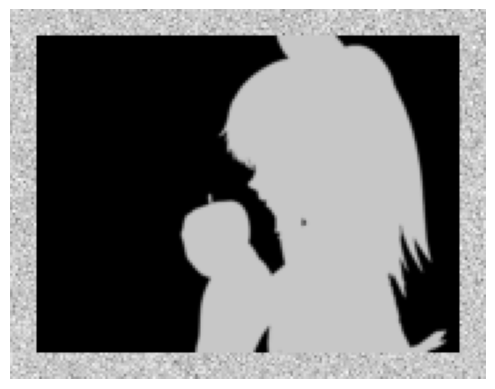

In [52]:
plt.axis('off')
plt.imshow(layer_output, cmap='Greys')

In [53]:
%%time
all_frames = np.zeros((81 * 81, 81 * 81), dtype=np.float32)
for i in range(81 * 81):
    all_frames[i, i] = 1
all_frames = all_frames.reshape(81 * 81, 81, 81)
out = ort_session.run(layer_output_names, {'input': all_frames} )
out = OrderedDict(zip(layer_output_names, out))

CPU times: user 1min 5s, sys: 1.34 s, total: 1min 6s
Wall time: 13.6 s


In [54]:
#from sys import getsizeof
#sum([getsizeof(value) for value in out.items()])
"{:,} MB".format(sum([value.nbytes for value in out.values()]) / 1e6)

'881.089828 MB'

In [55]:
out1 = out["/classifier/classifier.0/Gemm_output_0"]
out2 = out["output"]

print(softmax(out1, 1))
print(softmax(out2, 1))

[[0.02392572 0.6138436  0.07213708 ... 0.04097582 0.03385486 0.01945432]
 [0.02158401 0.63799995 0.06833214 ... 0.03885241 0.03073679 0.01828469]
 [0.0213155  0.63971424 0.06793025 ... 0.03877136 0.0305445  0.01830286]
 ...
 [0.02178929 0.63551253 0.06880545 ... 0.03858101 0.0310921  0.01845131]
 [0.02201412 0.6321742  0.0691089  ... 0.03897328 0.03150017 0.01872147]
 [0.02150747 0.63793385 0.06867821 ... 0.03938361 0.03047348 0.01860317]]
[[0.02392572 0.6138436  0.07213709 ... 0.04097582 0.03385485 0.01945433]
 [0.02158401 0.6379999  0.06833213 ... 0.03885241 0.03073678 0.01828469]
 [0.02131551 0.6397142  0.06793026 ... 0.03877136 0.0305445  0.01830286]
 ...
 [0.0217893  0.63551253 0.06880546 ... 0.03858102 0.03109211 0.01845131]
 [0.02201412 0.63217425 0.06910892 ... 0.03897328 0.03150018 0.01872148]
 [0.02150747 0.6379339  0.06867822 ... 0.03938361 0.03047348 0.01860318]]
